# QCNN

In [17]:
import pennylane as qml
import tensorflow as tf
from tensorflow import keras as K
from timeit import default_timer as timer
from datetime import timedelta
import pandas as pd
from os import listdir
import os
from matplotlib import image
from matplotlib import pyplot as plt
import h5py
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import itertools
from pennylane import numpy as np

In [19]:
# Counting labels
data_folder = 'all/data' # .mat files folder
sorted_data = sorted(listdir(data_folder))
labels = []
for file in sorted_data:
    f = h5py.File('all/data/'+file,'r')
    label = np.array(f.get("cjdata/label"))[0][0]
    labels.append(label)
labels = pd.Series(labels)
labels.shape

(3064,)

# Defining the Quantum Convolutiional Layer

In [23]:
dev4 = qml.device("default.qubit", wires=4) 
@qml.qnode(dev4)
def CONVCircuit(phi, wires, i=0):
    # parameter
    theta = np.pi / 2

    qml.RX(phi[0] * np.pi, wires=0)
    qml.RX(phi[1] * np.pi, wires=1)
    qml.RX(phi[2] * np.pi, wires=2)
    qml.RX(phi[3] * np.pi, wires=3)

    qml.CRZ(theta, wires=[1, 0])
    qml.CRZ(theta, wires=[3, 2])
    qml.CRX(theta, wires=[1, 0])
    qml.CRX(theta, wires=[3, 2])
    qml.CRZ(theta, wires=[2, 0])
    qml.CRX(theta, wires=[2, 0])
    # Expectation value
    measurement = qml.expval(qml.PauliZ(wires=0))    
    return measurement


def QCONV1(X, image_number, image_total, step=2):
    """
    quantum convolutional layer
    """

    H, W = X.shape
    step2 = 2
    out = np.zeros(((H//step), (W//step)))
    for i in range(0, W, step):
        print("processing image "+str(image_number)+"/ "+str(image_total)+": "+str(i)+"px   ", end="\r")
        for j in range(0, H, step):
            
            # get 2x2 pixels and make them 1D array
            phi = X[i:i+2, j:j+2].flatten()
            
            # Measurement
            measurement = CONVCircuit(phi, len(phi))
            out[i//step, j//step] = measurement

    return out

In [25]:
phi = [1, 1, 1, 1]
circ = qml.draw(CONVCircuit)
print(circ(phi, 4))

0: ──RX(3.14)─╭RZ(1.57)─╭RX(1.57)─╭RZ(1.57)─╭RX(1.57)─┤  <Z>
1: ──RX(3.14)─╰●────────╰●────────│─────────│─────────┤     
2: ──RX(3.14)─╭RZ(1.57)─╭RX(1.57)─╰●────────╰●────────┤     
3: ──RX(3.14)─╰●────────╰●────────────────────────────┤     


# Applying Quantum Conv Layer to all images

In [63]:
data_folder = 'all/data/' 
resized_Folder = 'all/resized/'
start = timer()
w = 512
step = 2

k = 0
directs = sorted(listdir(data_folder))

for file in directs:
    all64 = sorted(listdir(resized_Folder))
    if file+".npz" in all64:
        continue
    f = h5py.File(data_folder+file, 'r')
    img = np.array(f.get("cjdata/image"))
    if img.shape[0] < 512:
        continue
    label = np.array(f.get("cjdata/label"))[0][0]

    scale_percent = 25 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)

    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    NorImages = resized/255

    processed = QCONV1(NorImages, str(k)+" "+file, (len(directs)-len(all64))/2, step)

    np.savez_compressed(resized_Folder+file, image=processed, label=label)
    k+=1
end = timer()
time = (end - start)
str(timedelta(seconds=round(time)))

KeyboardInterrupt: 

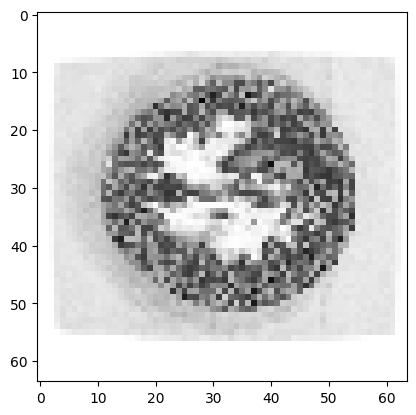

In [65]:
img = np.load("all/resized/175.mat.npz")['image']
plt.imshow(img, "gray")
plt.show()

In [67]:
# get processed data
folder = "all/resized/"
directs = sorted(listdir(folder))


images = []
masks = []
labels = []
i = 0
for file in directs:
    try:
        data = np.load(folder+file)
        label = data["label"]
        img = np.stack((data["image"],), axis=-1)
        images.append(img)
        labels.append(label)
        i+=1
    except:
        continue

npimages = np.asarray(images)
nplabels = np.asarray(labels)

In [68]:
npimages.shape, nplabels.shape

((833, 64, 64, 1), (833,))

In [71]:
X_train, X_test, y_train, y_test = train_test_split(npimages, nplabels,
                                                    test_size=0.3,
                                                    random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test,
                                                    test_size=0.5,
                                                    random_state=42)

In [73]:
X_train.shape, X_test.shape, X_valid.shape, y_valid.shape, y_train.shape, y_test.shape


((583, 64, 64, 1), (125, 64, 64, 1), (125, 64, 64, 1), (125,), (583,), (125,))

# CNN Model

In [82]:
def Model():
    model = K.models.Sequential([
        K.layers.Flatten(),
        K.layers.Dense(1024, activation="relu"),
        K.layers.Dropout(0.5),
        K.layers.Dense(4, activation="softmax")
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [84]:
### tf.random.set_seed(42)
q_model = Model()
checkpoint_path = "checkpoints/quantum.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

q_history = q_model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    batch_size=16,
    epochs=20,
    verbose=2,
    callbacks=[cp_callback]
)

Epoch 1/20
37/37 - 2s - 55ms/step - accuracy: 0.8542 - loss: 1.2427 - val_accuracy: 0.9840 - val_loss: 0.0496
Epoch 2/20
37/37 - 1s - 29ms/step - accuracy: 0.9657 - loss: 0.1506 - val_accuracy: 0.9520 - val_loss: 0.2233
Epoch 3/20
37/37 - 1s - 29ms/step - accuracy: 0.9811 - loss: 0.0820 - val_accuracy: 1.0000 - val_loss: 0.0067
Epoch 4/20
37/37 - 1s - 29ms/step - accuracy: 0.9828 - loss: 0.0628 - val_accuracy: 1.0000 - val_loss: 0.0064
Epoch 5/20
37/37 - 1s - 30ms/step - accuracy: 0.9777 - loss: 0.0778 - val_accuracy: 0.9920 - val_loss: 0.0128
Epoch 6/20
37/37 - 1s - 29ms/step - accuracy: 0.9949 - loss: 0.0154 - val_accuracy: 0.9760 - val_loss: 0.1052
Epoch 7/20
37/37 - 1s - 28ms/step - accuracy: 0.9846 - loss: 0.0450 - val_accuracy: 0.9760 - val_loss: 0.0670
Epoch 8/20
37/37 - 1s - 29ms/step - accuracy: 0.9949 - loss: 0.0112 - val_accuracy: 0.9760 - val_loss: 0.0810
Epoch 9/20
37/37 - 1s - 29ms/step - accuracy: 0.9914 - loss: 0.0331 - val_accuracy: 0.9840 - val_loss: 0.0285
Epoch 10/2

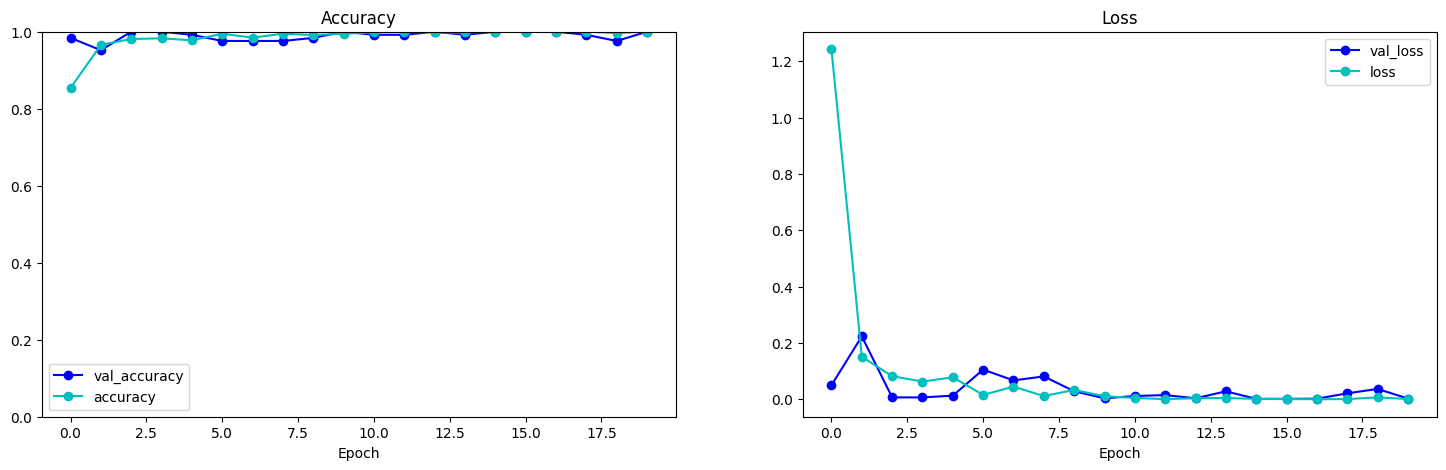

In [86]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
ax1.plot(q_history.history["val_accuracy"], "-ob", label="val_accuracy")
ax1.plot(q_history.history["accuracy"], "-oc", label="accuracy")
ax1.set_ylim([0, 1])
ax1.set_title("Accuracy")
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="val_loss")
ax2.plot(q_history.history["loss"], "-oc", label="loss")
ax2.set_title("Loss")
ax2.set_xlabel("Epoch")
ax2.legend()
plt.show()

In [88]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [90]:
q_model = K.models.load_model('QModel.h5')

C:\Users\hrith\anaconda3\envs\penny\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [92]:
yhat = q_model.predict(X_test)
yhat = yhat.argmax(axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [94]:
yhat.shape, y_test.shape

((125,), (125,))

Confusion matrix, without normalization


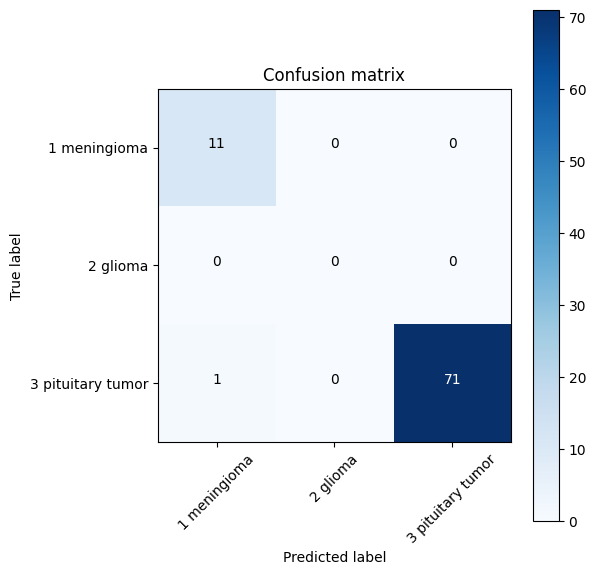

In [61]:
# Compute confusion matrix
cnf_matrix = tf.math.confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure(figsize=(6, 6))
plot_confusion_matrix(np.array(cnf_matrix[1:, 1:]), classes=['1 meningioma', '2 glioma', '3 pituitary tumor'], normalize=False,  title='Confusion matrix')

Confusion matrix, without normalization


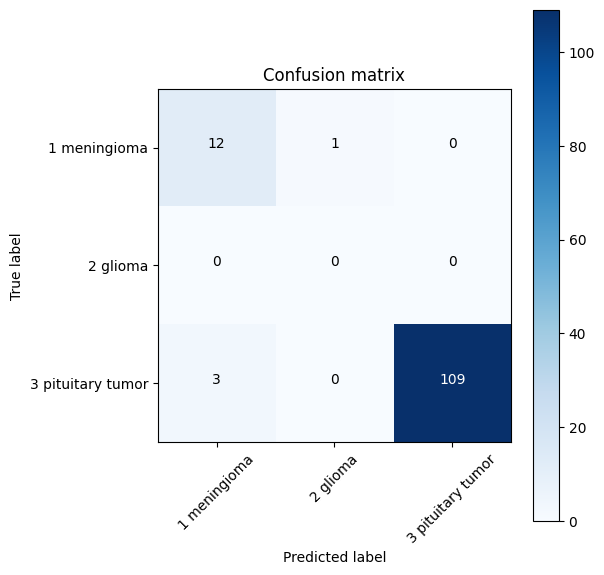

In [96]:
# Compute confusion matrix
cnf_matrix = tf.math.confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure(figsize=(6, 6))
plot_confusion_matrix(np.array(cnf_matrix[1:, 1:]), classes=['1 meningioma', '2 glioma', '3 pituitary tumor'], normalize=False,  title='Confusion matrix')